# Chapter 3

## Set Up

### Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

### Defaults

In [3]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

## 3.1 Sampling from a grid-approximate posterior

Posterior for the globe tossing model.

In [27]:
def calculate_posterior_from_globe_tossing(n_water, n_obs, n_grid=1000):
    p_grid = np.linspace(0, 1, n_grid)
    prior = stats.uniform.pdf(p_grid)
    likelihood = stats.binom.pmf(n_water, n_obs, p_grid)

    posterior = likelihood * prior
    posterior /= posterior.sum()
    
    return posterior, p_grid

In [28]:
posterior, p_grid = calculate_posterior_from_globe_tossing(6, 9)

Sample the posterior

In [25]:
n_sample = 10000
samples = np.random.choice(p_grid, size=n_sample, p=posterior, replace=True)

Plot samples and their distribution.

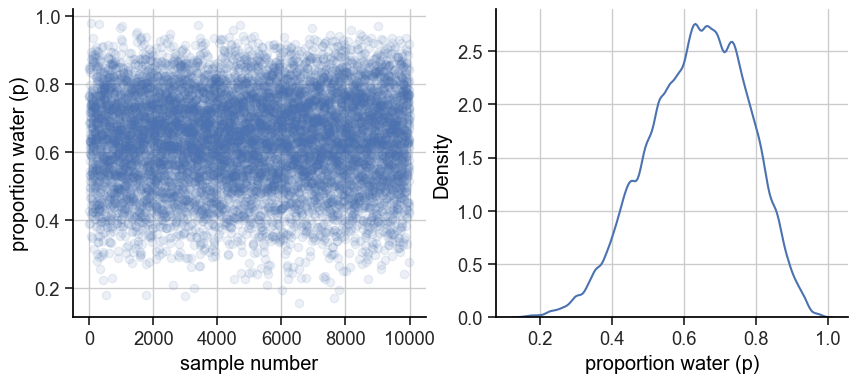

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

axs[0].scatter(np.arange(n_sample), samples, alpha=0.1)
axs[0].set(
    xlabel="sample number",
    ylabel="proportion water (p)",
)

sns.kdeplot(samples, bw_adjust=0.5, ax=axs[1]);
axs[1].set(
    xlabel="proportion water (p)",
);

## 3.2 Sampling to summarize

In [20]:
# sum probability below p=0.5
np.sum(posterior[p_grid < 0.5])

0.17187458902022873

In [21]:
# do the same using posterior sample
(samples < 0.5).mean()

0.1703

In [22]:
# maximum a posteriori estimate
p_grid[np.argmax(posterior)]

0.6666666666666666

Let's calculate the posterior for an observation of 3 waters.

In [65]:
posterior, p_grid = calculate_posterior_from_globe_tossing(3, 3)
samples = np.random.choice(p_grid, size=10000, p=posterior, replace=True)

Calculate the loss for a given estimate of $p$ given an absolute difference loss function

In [49]:
p = 0.5
np.sum(posterior * np.abs(p - p_grid))

0.31287518749981214

We can do this for a grid of p values to plot the loss

In [53]:
def calculate_loss(p, posterior, posterior_grid, loss_function):
    """
    p: array of shape (m,)
    posterior: array of shape (n,)
    posterior_grid: grid of shape (n,)
    loss_function: function that gives elementwise loss(a, b) for arrays a, b of same shape
    """
    # create arrays pv = (p.T, p.T, ...).T and gridv = (grid, grid,...) of shape (n, m)
    pv, gridv = np.meshgrid(p, posterior_grid)
    
    # get all combinations of loss and weight by probability density
    # result is loss for all values of p, shape (m,)
    loss = posterior @ loss_function(pv, gridv)
    
    return loss

In [70]:
def absolute_diff(a, b):
    return np.abs(a - b)

def squared_diff(a, b):
    return (a - b)**2

p_val = np.linspace(0, 1, 100)
abs_diff_loss = calculate_loss(p_val, posterior, p_grid, absolute_diff)
squared_diff_loss = calculate_loss(p_val, posterior, p_grid, squared_diff)

Plot the different losses against p values as well as the posterior distribution

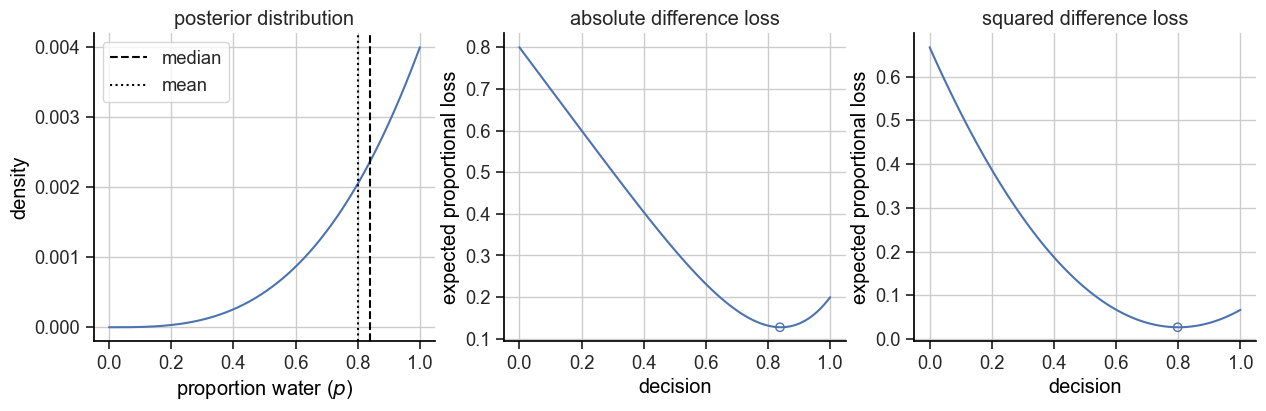

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 4))

# plot posterior distribution with its mean and median
ax1.plot(p_grid, posterior)

median = np.median(samples)
ax1.axvline(median, ls="--", color="black", label="median")

mean = np.mean(samples)
ax1.axvline(mean, ls=":", color="black", label="mean")

ax1.set(
    title="posterior distribution",
    xlabel="proportion water ($p$)",
    ylabel="density",
)
ax1.legend()

# plot the losses
losses = {
    "absolute difference": abs_diff_loss,
    "squared difference": squared_diff_loss,
}
for ax, (loss_name, loss) in zip((ax2, ax3), losses.items()):
    # plot loss
    ax.plot(p_val, loss)
    
    # plot best loss
    best_loss = np.min(loss)
    p_best = p_val[np.argmin(loss)]
    ax.scatter(p_best, best_loss, edgecolor='b', facecolor='none')

    ax.set(
        title=f"{loss_name} loss",
        xlabel="decision",
        ylabel="expected proportional loss",
    );

## 3.3 Sampling to simulation prediction

Simulate sampling from a binomial distribution

In [89]:
# actual probabilities
stats.binom.pmf(np.arange(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

In [100]:
# compare with sampling
n_sample = 100000
dummy_obs = stats.binom.rvs(size=n_sample, n=2, p=0.7)

_, counts = np.unique(dummy_obs, return_counts=True)
(counts / n_sample).round(3)

array([0.089, 0.42 , 0.491])

A histogram of a sample with more tosses. 

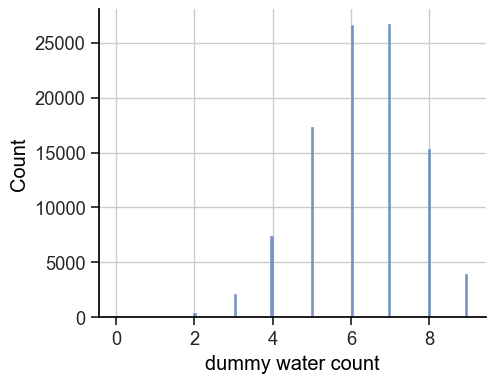

In [94]:
n_sample = 100000
dummy_obs = stats.binom.rvs(size=n_sample, n=9, p=0.7)

fig, ax = plt.subplots(figsize=(5, 4))

sns.histplot(dummy_obs, ax=ax)
ax.set(xlabel="dummy water count");

Now let's try sampling from a posterior predictive distribution

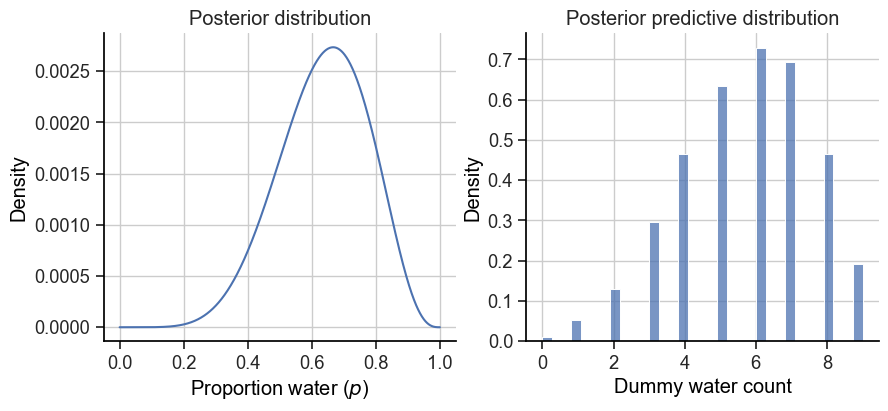

In [108]:
posterior, p_grid = calculate_posterior_from_globe_tossing(6, 9)

n_samples = 10000
post_samples = np.random.choice(p_grid, size=n_samples, replace=True, p=posterior)
pp_samples = stats.binom.rvs(n=9, p=post_samples, size=n_samples)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# plot posterior dist
ax1.plot(p_grid, posterior)
ax1.set(
    title="Posterior distribution",
    xlabel="Proportion water ($p$)",
    ylabel="Density",
)

# posterior predictive distribution
sns.histplot(pp_samples, stat="density",ax=ax2)
ax2.set(
    title="Posterior predictive distribution",
    xlabel="Dummy water count"
);